In [52]:
# Copyright 2016, Yarin Gal, All rights reserved.
# This code is based on the code by Jose Miguel Hernandez-Lobato used for his 
# paper "Probabilistic Backpropagation for Scalable Learning of Bayesian Neural Networks".

import warnings
warnings.filterwarnings("ignore")

import math
from scipy.special import logsumexp
import numpy as np

from keras.regularizers import l2
from keras import Input
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Softmax
from keras import Model
import tensorflow as tf

import time


class net:

    def __init__(self, X_train, y_train, n_hidden, n_epochs = 40,
        normalize = False, tau = 1.0, dropout = 0.05):

        """
            Constructor for the class implementing a Bayesian neural network
            trained with the probabilistic back propagation method.

            @param X_train      Matrix with the features for the training data.
            @param y_train      Vector with the target variables for the
                                training data.
            @param n_hidden     Vector with the number of neurons for each
                                hidden layer.
            @param n_epochs     Numer of epochs for which to train the
                                network. The recommended value 40 should be
                                enough.
            @param normalize    Whether to normalize the input features. This
                                is recommended unles the input vector is for
                                example formed by binary features (a
                                fingerprint). In that case we do not recommend
                                to normalize the features.
            @param tau          Tau value used for regularization
            @param dropout      Dropout rate for all the dropout layers in the
                                network.
        """
        # We normalize the training data to have zero mean and unit standard
        # deviation in the training set if necessary

#         if normalize:
#             self.std_X_train = np.std(X_train, 0)
#             self.std_X_train[ self.std_X_train == 0 ] = 1
#             self.mean_X_train = np.mean(X_train, 0)
#         else:
#             self.std_X_train = np.ones(X_train.shape[ 1 ])
#             self.mean_X_train = np.zeros(X_train.shape[ 1 ])

#         X_train = (X_train - np.full(X_train.shape, self.mean_X_train)) / \
#             np.full(X_train.shape, self.std_X_train)

#         self.mean_y_train = np.mean(y_train)
#         self.std_y_train = np.std(y_train)

#         y_train_normalized = (y_train - self.mean_y_train) / self.std_y_train
#         y_train_normalized = np.array(y_train_normalized, ndmin = 2).T
        
        # We construct the network
        N = X_train.shape[0]
        batch_size = 128
        lengthscale = 1e-2
        reg = lengthscale**2 * (1 - dropout) / (2. * N * tau)

        inputs = Input(shape=(X_train.shape[1],))
        inter = Dropout(dropout)(inputs, training=True)
        inter = Dense(n_hidden[0], activation='relu', kernel_regularizer=l2(reg))(inter)
        for i in range(1, len(n_hidden) - 1):
            inter = Dropout(dropout)(inter, training=True)
            inter = Dense(n_hidden[i], activation='relu', kernel_regularizer=l2(reg))(inter)
        inter = Dropout(dropout)(inter, training=True)
        outputs = Dense(2, kernel_regularizer=l2(reg))(inter)
        outputs = Softmax()(outputs)
        model = Model(inputs, outputs)

        model.compile(loss='binary_crossentropy', optimizer='adam')
#         print(model.summary())
        # We iterate the learning process
        start_time = time.time()
        model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=0)
        self.model = model
        self.tau = tau
        self.running_time = time.time() - start_time

        # We are done!

    def predict(self, X_test, y_test):

        """
            Function for making predictions with the Bayesian neural network.

            @param X_test   The matrix of features for the test data
            
    
            @return m       The predictive mean for the test target variables.
            @return v       The predictive variance for the test target
                            variables.
            @return v_noise The estimated variance for the additive noise.

        """
        X_test = np.array(X_test, ndmin = 2)
        y_test = np.array(y_test, ndmin = 2).T

        # We normalize the test set

#         X_test = (X_test - np.full(X_test.shape, self.mean_X_train)) / \
#             np.full(X_test.shape, self.std_X_train)

        # We compute the predictive mean and variance for the target variables
        # of the test data

        model = self.model
        standard_pred_probs = model.predict(X_test, batch_size=500, verbose=1)
        standard_pred = tf.math.argmax(standard_pred_probs, axis=1).numpy()
        # standard_pred = standard_pred * self.std_y_train + self.mean_y_train
        # rmse_standard_pred = np.mean((y_test.squeeze() - standard_pred.squeeze())**2.)**0.5
        accuracy_standard_pred = np.mean((y_test.squeeze() == standard_pred.squeeze()))
        print(f'Standard Accuracy: {accuracy_standard_pred}')

        # Number of stochastic forward passes which will then be averaged
        # originally 10_000 in the paper's code. Set to 100 here for speed.
        T = 100
        
        Yt_hat = np.array([model.predict(X_test, batch_size=64, verbose=0) for _ in range(T)])
        # Yt_hat = Yt_hat * self.std_y_train + self.mean_y_train
        MC_pred = tf.math.argmax(np.mean(Yt_hat, axis=0), axis=1).numpy()
        # print(MC_pred.shape)
        mc_accuracy = np.mean((y_test.squeeze() == MC_pred.squeeze()))
        print(f'MC Accuracy: {mc_accuracy}')

        # We compute the test log-likelihood
        # ll = (logsumexp(-0.5 * self.tau * (y_test[None] - Yt_hat)**2., 0) - np.log(T) 
        #     - 0.5*np.log(2*np.pi) + 0.5*np.log(self.tau))
        # test_ll = np.mean(ll)
        # ll = np.sum(y_test[])
        
        # double check this!
        y_test = y_test.astype(int)
        y_test_2d = np.hstack((y_test, 1-y_test))
        test_ll = -np.mean(np.log(standard_pred_probs) * y_test_2d)

        # We are done!
        print(f'Test LL: {test_ll}')
        return accuracy_standard_pred, mc_accuracy, test_ll


In [53]:
# Copyright 2016, Yarin Gal, All rights reserved.
# This code is based on the code by Jose Miguel Hernandez-Lobato used for his 
# paper "Probabilistic Backpropagation for Scalable Learning of Bayesian Neural Networks".

# This file contains code to train dropout networks on the UCI datasets using the following algorithm:
# 1. Create 20 random splits of the training-test dataset.
# 2. For each split:
# 3.   Create a validation (val) set taking 20% of the training set.
# 4.   Get best hyperparameters: dropout_rate and tau by training on (train-val) set and testing on val set.
# 5.   Train a network on the entire training set with the best pair of hyperparameters.
# 6.   Get the performance (MC RMSE and log-likelihood) on the test set.
# 7. Report the averaged performance (Monte Carlo RMSE and log-likelihood) on all 20 splits.

import math
import numpy as np
from sklearn.model_selection import train_test_split

# We fix the random seed

np.random.seed(1)

def write_to_file(filename, txt, dropout_rate, tau):
    with open(filename, "a") as myfile:
        myfile.write('Dropout_Rate: ' + repr(dropout_rate) + ' Tau: ' + repr(tau) + ' :: ')
        myfile.write(repr(txt) + '\n')

        
def run_half_moons_experiment(X, y, hidden_layers, n_epochs, epoch_multiplier, dropout_rates, taus, normalize):
    num_training_examples = int(0.8 * X.shape[0])
    X_validation = X[num_training_examples:, :]
    y_validation = y[num_training_examples:]
    X_train = X[0:num_training_examples, :]
    y_train = y[0:num_training_examples]
    
    # Printing the size of the training, validation and test sets
    print('Number of training examples: ' + str(X_train.shape[0]))
    print('Number of validation examples: ' + str(X_validation.shape[0]))
    print('Number of test examples: ' + str(X_test.shape[0]))
    print('Number of train_original examples: ' + str(X.shape[0]))
    print(f'Dropout rates: {dropout_rates}')
    print(f'Taus: {taus}')
    
    # We perform grid-search to select the best hyperparameters based on the highest log-likelihood value
    best_network = None
    best_ll = -float('inf')
    best_tau = None
    best_dropout = None
    for dropout_rate in dropout_rates:
        for tau in taus:
            print ('Grid search step: Tau: ' + str(tau) + ' Dropout rate: ' + str(dropout_rate))
            network = net(X_train, y_train, hidden_layers,
                              normalize = normalize,
                              n_epochs = int(n_epochs * epochs_multiplier),
                              tau = tau,
                              dropout = dropout_rate
                             )
            print('DONE TRAINING')

            # We obtain the test accuracy and the test ll from the validation sets
            accuracy, MC_accuracy, ll = network.predict(X_validation, y_validation)
            print('DONE PREDICTING')
            if (ll > best_ll):
                best_ll = ll
                best_network = network
                best_tau = tau
                best_dropout = dropout_rate
                print ('Best log_likelihood changed to: ' + str(best_ll))
                print ('Best tau changed to: ' + str(best_tau))
                print ('Best dropout rate changed to: ' + str(best_dropout))
            
            # Storing validation results
            write_to_file(_RESULTS_VALIDATION_ACC, accuracy, dropout_rate, tau)
            write_to_file(_RESULTS_VALIDATION_MC_ACC, MC_accuracy, dropout_rate, tau)
            write_to_file(_RESULTS_VALIDATION_LL, ll, dropout_rate, tau)
            

    # Storing test results
    best_network = net(X_train, y_train, hidden_layers,
                    normalize = True, n_epochs = int(n_epochs * epochs_multiplier), tau = best_tau,
                    dropout = best_dropout)
    
    return best_network

In [56]:
data_directory = 'half_moons'

# We delete previous results

from subprocess import call

epochs_multiplier = 1
num_hidden_layers = 2
n_splits = 20
hidden_layers = [50] * num_hidden_layers
n_epochs = 50
epochs_multiplier = 100
dropout_rates = [0.005, 0.01, 0.05, 0.1]
taus = [0.25, 0.5, 0.75]

_RESULTS_VALIDATION_LL = "./UCI_Datasets/" + data_directory + "/results/validation_ll_" + str(epochs_multiplier) + "_xepochs_" + str(num_hidden_layers) + "_hidden_layers.txt"
_RESULTS_VALIDATION_RMSE = "./UCI_Datasets/" + data_directory + "/results/validation_rmse_" + str(epochs_multiplier) + "_xepochs_" + str(num_hidden_layers) + "_hidden_layers.txt"
_RESULTS_VALIDATION_MC_RMSE = "./UCI_Datasets/" + data_directory + "/results/validation_MC_rmse_" + str(epochs_multiplier) + "_xepochs_" + str(num_hidden_layers) + "_hidden_layers.txt"
_RESULTS_VALIDATION_ACC = "./UCI_Datasets/" + data_directory + "/results/validation_acc_" + str(epochs_multiplier) + "_xepochs_" + str(num_hidden_layers) + "_hidden_layers.txt"
_RESULTS_VALIDATION_MC_ACC = "./UCI_Datasets/" + data_directory + "/results/validation_MC_acc_" + str(epochs_multiplier) + "_xepochs_" + str(num_hidden_layers) + "_hidden_layers.txt"

_RESULTS_TEST_LL = "./UCI_Datasets/" + data_directory + "/results/test_ll_" + str(epochs_multiplier) + "_xepochs_" + str(num_hidden_layers) + "_hidden_layers.txt"
_RESULTS_TEST_TAU = "./UCI_Datasets/" + data_directory + "/results/test_tau_" + str(epochs_multiplier) + "_xepochs_" + str(num_hidden_layers) + "_hidden_layers.txt"
_RESULTS_TEST_RMSE = "./UCI_Datasets/" + data_directory + "/results/test_rmse_" + str(epochs_multiplier) + "_xepochs_" + str(num_hidden_layers) + "_hidden_layers.txt"
_RESULTS_TEST_MC_RMSE = "./UCI_Datasets/" + data_directory + "/results/test_MC_rmse_" + str(epochs_multiplier) + "_xepochs_" + str(num_hidden_layers) + "_hidden_layers.txt"
_RESULTS_TEST_LOG = "./UCI_Datasets/" + data_directory + "/results/log_" + str(epochs_multiplier) + "_xepochs_" + str(num_hidden_layers) + "_hidden_layers.txt"
_RESULTS_TEST_ACC = "./UCI_Datasets/" + data_directory + "/results/test_acc_" + str(epochs_multiplier) + "_xepochs_" + str(num_hidden_layers) + "_hidden_layers.txt"
_RESULTS_TEST_MC_ACC = "./UCI_Datasets/" + data_directory + "/results/test_MC_acc_" + str(epochs_multiplier) + "_xepochs_" + str(num_hidden_layers) + "_hidden_layers.txt"

_DATA_DIRECTORY_PATH = "./UCI_Datasets/" + data_directory + "/data/"
_DROPOUT_RATES_FILE = _DATA_DIRECTORY_PATH + "dropout_rates.txt"
_TAU_VALUES_FILE = _DATA_DIRECTORY_PATH + "tau_values.txt"
_DATA_FILE = _DATA_DIRECTORY_PATH + "data.txt"
_HIDDEN_UNITS_FILE = _DATA_DIRECTORY_PATH + "n_hidden.txt"
_EPOCHS_FILE = _DATA_DIRECTORY_PATH + "n_epochs.txt"
_INDEX_FEATURES_FILE = _DATA_DIRECTORY_PATH + "index_features.txt"
_INDEX_TARGET_FILE = _DATA_DIRECTORY_PATH + "index_target.txt"
_N_SPLITS_FILE = _DATA_DIRECTORY_PATH + "n_splits.txt"

print ("Removing existing result files...")
call(["rm", _RESULTS_VALIDATION_LL])
call(["rm", _RESULTS_VALIDATION_RMSE])
call(["rm", _RESULTS_VALIDATION_MC_RMSE])
call(["rm", _RESULTS_VALIDATION_ACC])
call(["rm", _RESULTS_VALIDATION_MC_ACC])
call(["rm", _RESULTS_TEST_LL])
call(["rm", _RESULTS_TEST_TAU])
call(["rm", _RESULTS_TEST_RMSE])
call(["rm", _RESULTS_TEST_MC_RMSE])
call(["rm", _RESULTS_TEST_ACC])
call(["rm", _RESULTS_TEST_MC_ACC])
call(["rm", _RESULTS_TEST_LOG])
print ("Result files removed.")

Removing existing result files...
Result files removed.


rm: ./UCI_Datasets/half_moons/results/validation_rmse_100_xepochs_2_hidden_layers.txt: No such file or directory
rm: ./UCI_Datasets/half_moons/results/validation_MC_rmse_100_xepochs_2_hidden_layers.txt: No such file or directory
rm: ./UCI_Datasets/half_moons/results/test_rmse_100_xepochs_2_hidden_layers.txt: No such file or directory
rm: ./UCI_Datasets/half_moons/results/test_MC_rmse_100_xepochs_2_hidden_layers.txt: No such file or directory
rm: ./UCI_Datasets/half_moons/results/log_100_xepochs_2_hidden_layers.txt: No such file or directory


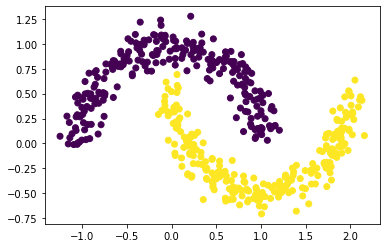

[1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1
 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1
 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1
 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0
 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0
 1 0 0 0 1 1 0 1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1
 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1
 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0
 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1
 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1
 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0
 1 1 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0
 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0
 1 0 1 0 0 1 0 1 1 1 0 0 


KeyboardInterrupt



In [60]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, y = make_moons(500, noise=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

from sklearn.preprocessing import LabelEncoder

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
print(encoded_Y)

accuracies, MC_accuracies, lls = [], [], []
for i in range(n_splits):
    X_train, X_test, y_train, y_test = train_test_split(X, encoded_Y, train_size=0.8, random_state=100)
    print(y_train.mean())
    print(y_test.mean())
    
    # tune on train and validation sets, returning best trained neural network
    best_network_trained =  run_half_moons_experiment(X_train,
                                                      y_train,
                                                      hidden_layers,
                                                      n_epochs,
                                                      epochs_multiplier,
                                                      dropout_rates,
                                                      taus,
                                                      normalize=False
                                                     )
    
    # predict on held out test set
    accuracy, MC_accuracy, ll = best_network_trained.predict(X_test, y_test)
    
    with open(_RESULTS_TEST_ACC, "a") as myfile:
        myfile.write(repr(accuracy) + '\n')

    with open(_RESULTS_TEST_MC_ACC, "a") as myfile:
        myfile.write(repr(MC_accuracy) + '\n')

    with open(_RESULTS_TEST_LL, "a") as myfile:
        myfile.write(repr(ll) + '\n')

    with open(_RESULTS_TEST_TAU, "a") as myfile:
        myfile.write(repr(best_network_trained.tau) + '\n')

    print ("Tests on split " + str(i) + " complete.")
    
    accuracies.append(accuracy)
    MC_accuracies.append(MC_accuracy)
    lls.append(ll)

with open(_RESULTS_TEST_LOG, "a") as myfile:
    myfile.write('accuracies %f +- %f (stddev) +- %f (std error), median %f 25p %f 75p %f \n' % (
        np.mean(accuracies), np.std(accuracies), np.std(accuracies)/math.sqrt(n_splits),
        np.percentile(accuracies, 50), np.percentile(accuracies, 25), np.percentile(accuracies, 75)))
    myfile.write('MC accuracies %f +- %f (stddev) +- %f (std error), median %f 25p %f 75p %f \n' % (
        np.mean(MC_accuracies), np.std(MC_accuracies), np.std(MC_accuracies)/math.sqrt(n_splits),
        np.percentile(MC_accuracies, 50), np.percentile(MC_accuracies, 25), np.percentile(MC_accuracies, 75)))
    myfile.write('lls %f +- %f (stddev) +- %f (std error), median %f 25p %f 75p %f \n' % (
        np.mean(lls), np.std(lls), np.std(lls)/math.sqrt(n_splits), 
        np.percentile(lls, 50), np.percentile(lls, 25), np.percentile(lls, 75)))